In [1]:
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

dim = 3
n_particles = int(1e5)
n_subdivisions = 50
save_folder = '../data/Thomas'
n_steps = 50
n_repeats = 10
dt = 0.1
r = 1.0
sigma = np.sqrt(2.)
s = 1.
t = n_steps *dt
def mu_np(X, b=0.2):
    x, y, z = np.split(X, 3, axis=-1)
    p = np.sin(s*y) - b*x 
    q = np.sin(s*z) - b*y 
    r = np.sin(s*x) - b*z
    return np.concatenate([p, q, r], axis=-1)


X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones(dim)).sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivisions, mu_np, sigma, X0, tick_size=20, title_size=20, cbar_tick_size=15)
mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)
#mc_prob.compute_all(n_steps=n_steps, dt=dt)

C:\Users\pinak\Documents\GitHub\non-grad3D
Time taken by propagate is 0.6243250370025635 seconds
Time taken by set_grid is 0.26462507247924805 seconds
Time taken by assign_pts is 0.31709909439086914 seconds
Time taken by ready is 1.2070491313934326 seconds


<IPython.core.display.Javascript object>


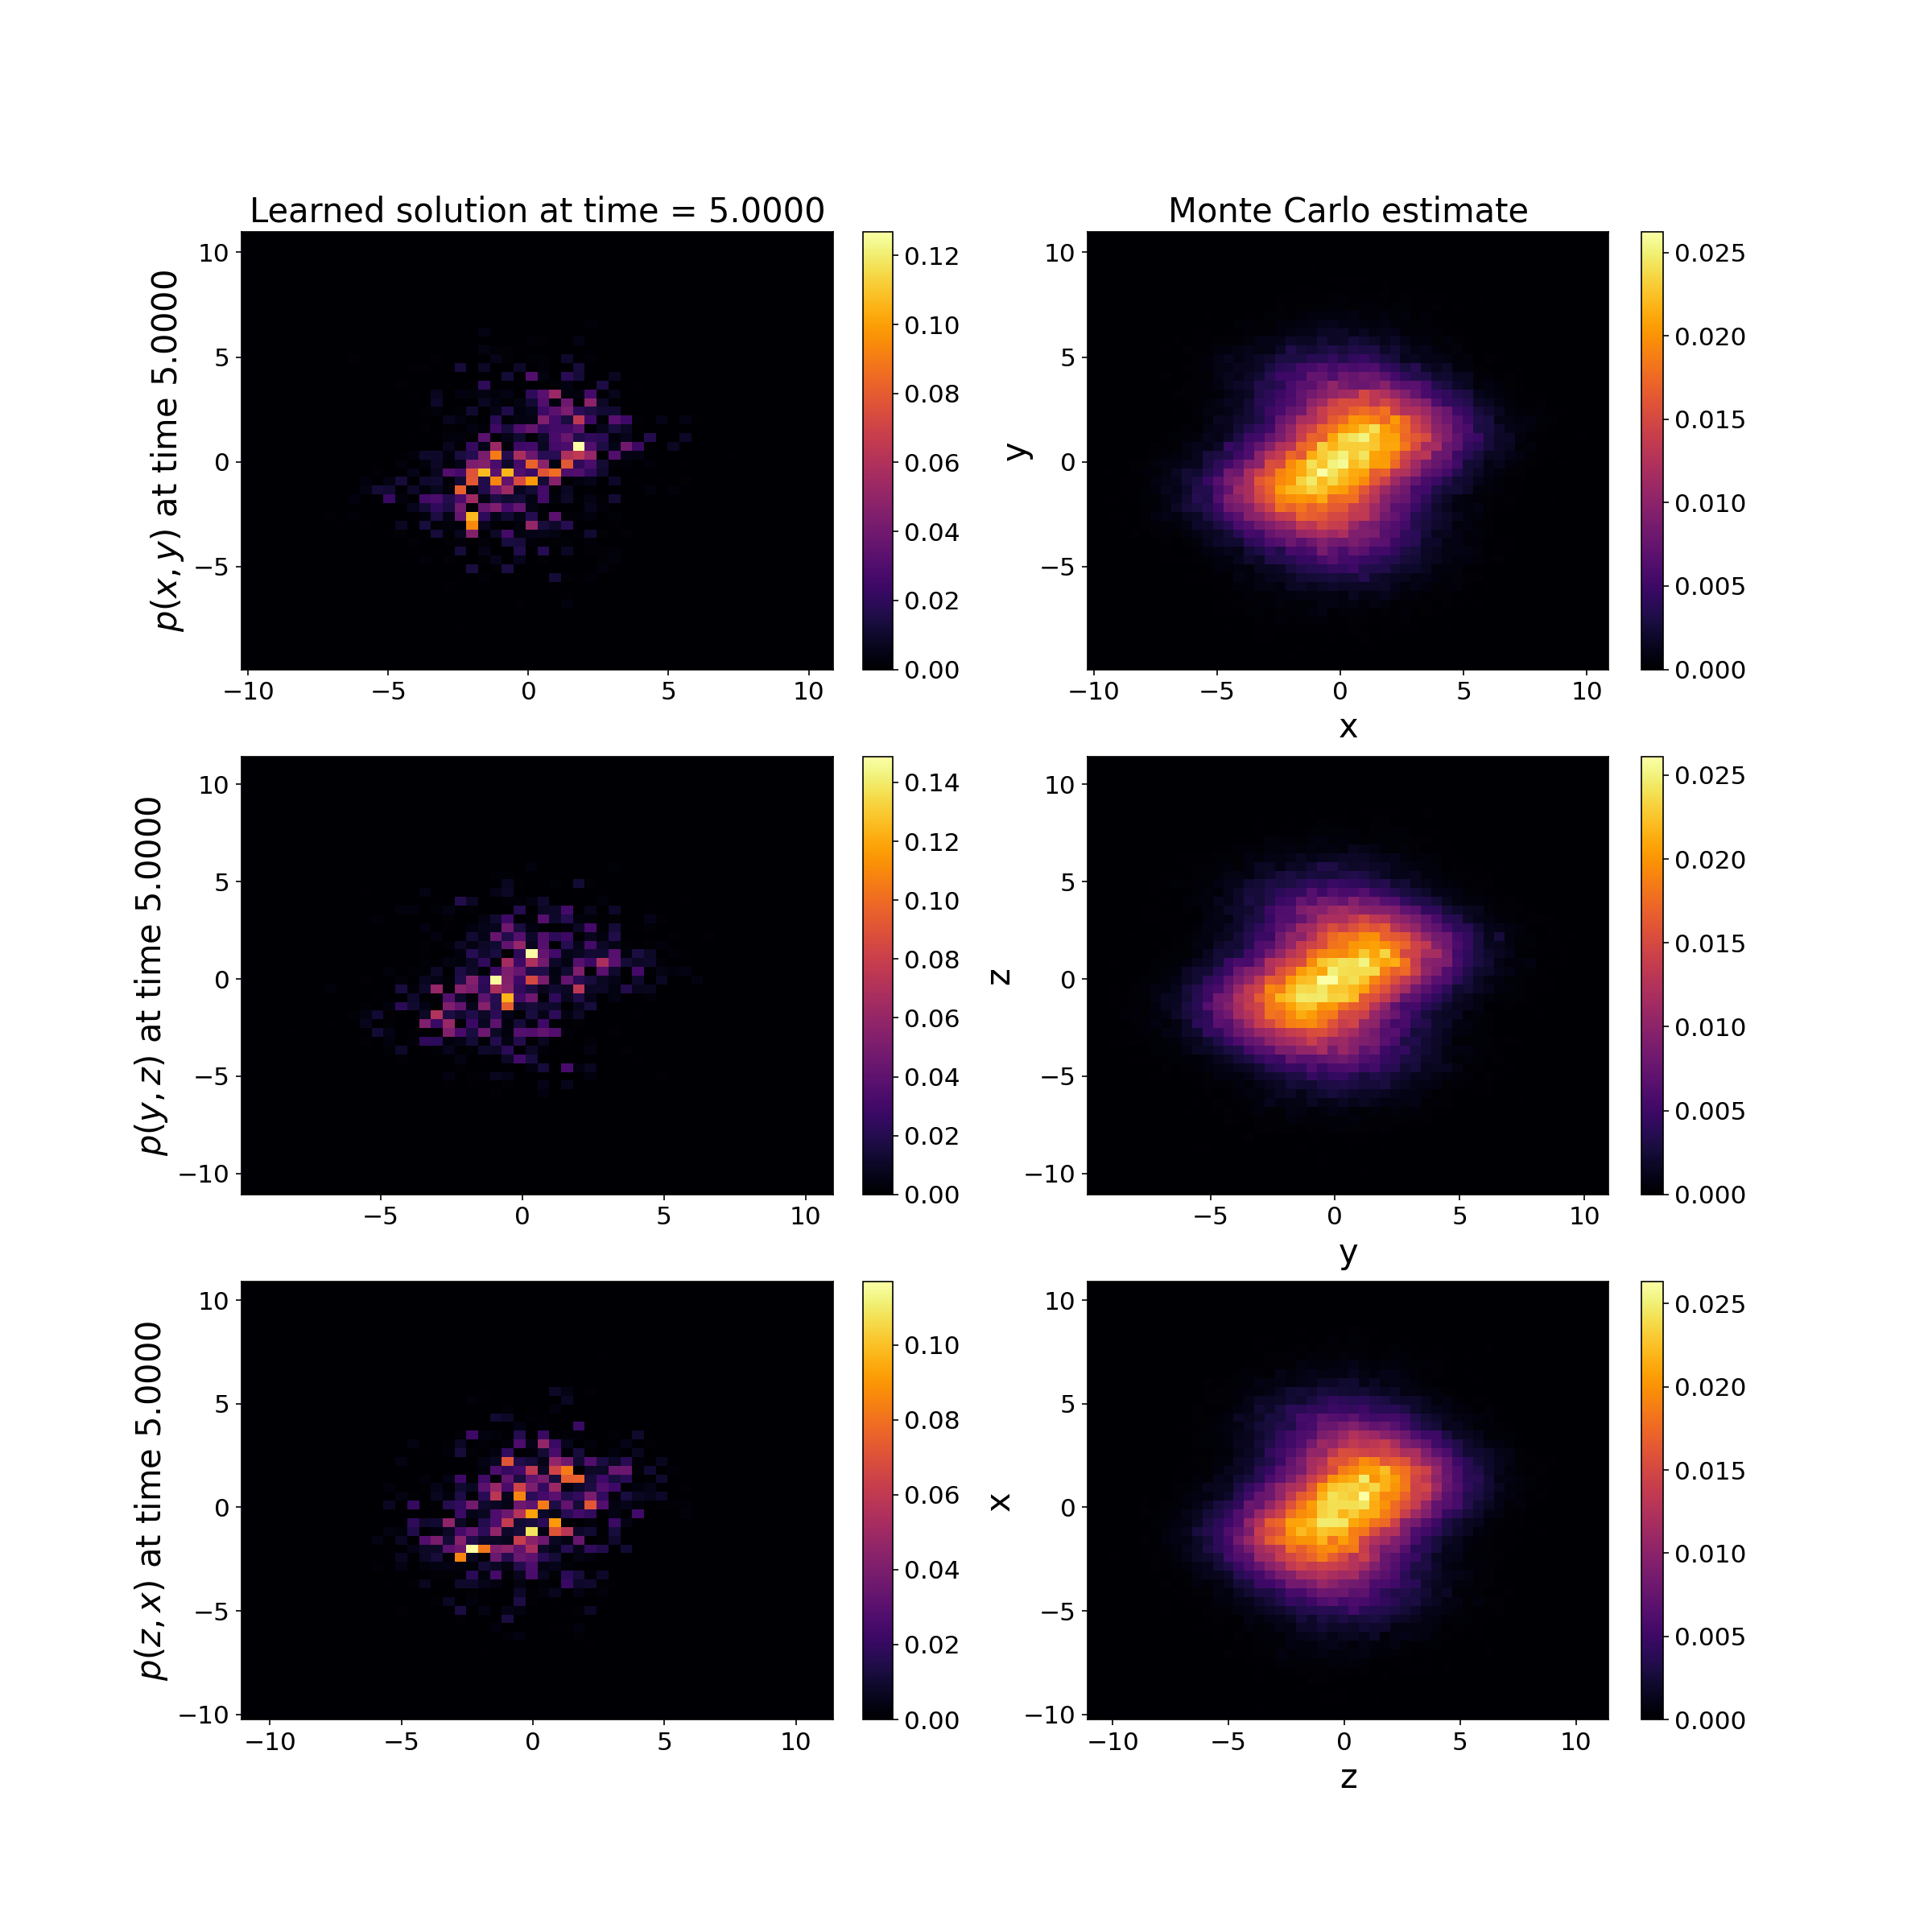

Time taken by compute_p2 is 0.30364441871643066 seconds
Time taken by compute_p2 is 0.29559993743896484 seconds
Time taken by compute_p2 is 0.2938194274902344 seconds
(1250000, 3)
(1250000, 3)
Time taken by propagate is 5.984546899795532 seconds
Time taken by compile is 0.5321249961853027 seconds


In [10]:
def get_net(iter):
    net = arch.LSTMForgetNet(num_nodes=50, num_blocks=3)
    if iter < 500:
        net.load_weights('../data/Thomas-true-vs-learned/init/Thomas_{}'.format(iter)).expect_partial()
    elif iter < 10000:
        net.load_weights('../data/Thomas-true-vs-learned/Thomas_{}'.format(iter)).expect_partial()
    else:
        net.load_weights('../data/Thomas/400k/Thomas').expect_partial()
    return net



s = 1.0
# define drift
def mu(X):
    return -mu_np(X)

n_theta = get_net(1000000)

# define h0
r = 1.
def h0(X):
    l = len(X)
    m = int(1e5)
    M = int(np.ceil(l / m))
    data = []
    for i in range(M):
        if i < M-1:
            x_, y_, z_ = tf.split(X[i*m: (i+1)*m], [1, 1, 1], axis=-1)
        else:
            x_, y_, z_ = tf.split(X[i*m:], [1, 1, 1], axis=-1)
        log_p0 = (- (x_**2 + y_**2 + z_**2) / (2.*r**2)).numpy()
        log_pinf = n_theta(x_, y_, z_).numpy()
        data.append(np.exp(log_p0 - log_pinf) / (2. * np.pi * r**2) ** (1.5))
        
    return np.concatenate(data, axis=0) 
    
def sol(X):
    l = len(X)
    m = int(1e5)
    M = int(np.ceil(l / m))
    data = []
    for i in range(M):
        if i < M-1:
            x_, y_, z_ = tf.split(X[i*m: (i+1)*m], [1, 1, 1], axis=-1)
        else:
            x_, y_, z_ = tf.split(X[i*m:], [1, 1, 1], axis=-1) 
        data.append(np.exp(n_theta(x_, y_, z_).numpy()))
        
    return np.concatenate(data, axis=0) 



grid = mc_prob.get_grid()
low = grid.mins
high = grid.maxs
n_subdivs = n_subdivisions
x = np.linspace(low[0], high[0], num=n_subdivs+1, endpoint=True).astype('float32')[1:]
y = np.linspace(low[1], high[1], num=n_subdivs+1, endpoint=True).astype('float32')[1:]
z = np.linspace(low[2], high[2], num=n_subdivs+1, endpoint=True).astype('float32')[1:]
x, y, z = np.meshgrid(x, y, z, indexing='ij')
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = z.reshape(-1, 1)
x_ = np.linspace(low[0], high[0], num=n_subdivs, endpoint=True).astype('float32')
y_ = np.linspace(low[1], high[1], num=n_subdivs, endpoint=True).astype('float32')
z_ = np.linspace(low[2], high[2], num=n_subdivs, endpoint=True).astype('float32')
iters = list(range(0, 500, 1)) + list(range(500, 10000, 100)) + [800000]*24
nets = {iter: get_net(iter) for iter in iters}

    
fig_all = plt.figure(figsize=(16, 16))
ax_1l = fig_all.add_subplot(321) 
ax_1m = fig_all.add_subplot(322)


ax_2l = fig_all.add_subplot(323) 
ax_2m = fig_all.add_subplot(324)

ax_3l = fig_all.add_subplot(325) 
ax_3m = fig_all.add_subplot(326)


div_1 = make_axes_locatable(ax_1l)
cax_1 = div_1.append_axes('right', '5%', '5%')
div_2 = make_axes_locatable(ax_2l)
cax_2 = div_2.append_axes('right', '5%', '5%')
div_3 = make_axes_locatable(ax_3l)
cax_3 = div_3.append_axes('right', '5%', '5%')

tick_size = 15
title_size = 20
cbar_tick_size = 15

im = ax_1m.pcolormesh(x_, y_, mc_prob.compute_p2(0, 1, save=False).T, cmap='inferno', shading='auto')
cbar = fig_all.colorbar(im, ax=ax_1m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1m.set_aspect("auto")

im = ax_2m.pcolormesh(y_, z_, mc_prob.compute_p2(1, 2, save=False).T, cmap='inferno', shading='auto')
cbar = fig_all.colorbar(im, ax=ax_2m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_2m.set_aspect("auto")

im = ax_3m.pcolormesh(z_, x_, mc_prob.compute_p2(2, 0, save=False).T, cmap='inferno', shading='auto')
cbar = fig_all.colorbar(im, ax=ax_3m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_3m.set_aspect("auto")

ax_1m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='minor', labelsize=tick_size)

ax_1m.set_title('Monte Carlo estimate', fontsize=title_size)
ax_1m.set_xlabel('x', fontsize=title_size)
ax_1m.set_ylabel('y', fontsize=title_size)
ax_2m.set_xlabel('y', fontsize=title_size)
ax_2m.set_ylabel('z', fontsize=title_size)
ax_3m.set_xlabel('z', fontsize=title_size)
ax_3m.set_ylabel('x', fontsize=title_size)



fk = sim.FKSim3_2(save_folder='.', n_subdivs=n_subdivs, mu=mu, sigma=sigma, sol=sol, grid=grid, h0=h0)
fk.propagate(n_steps, dt, n_repeats)
z_1l, z_2l, z_3l = fk.compile(n_repeats) 


ax_1l.clear()
cax_1.cla()

z_1l /= (z_1l.sum() * grid.h[0] * grid.h[1])
im = ax_1l.pcolormesh(x_, y_, z_1l.T, cmap='inferno')
ax_1l.set_title('Learned solution at time = {:.4f}'.format(t), fontsize=title_size)
ax_1l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_1, ax=ax_1l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1l.set_aspect("auto")

ax_2l.clear()
cax_2.cla() 
z_2l /= (z_2l.sum() *  grid.h[1] * grid.h[2])
im = ax_2l.pcolormesh(y_, z_, z_2l.T, cmap='inferno')
ax_2l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_2l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_2, ax=ax_2l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_2l.set_aspect("auto")

ax_3l.clear()
cax_3.cla()
z_3l /= (z_3l.sum() *  grid.h[2] * grid.h[0])
im = ax_3l.pcolormesh(z_, x_, z_3l, cmap='inferno')
ax_3l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_3l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_3, ax=ax_3l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_3l.set_aspect("auto")
fig_all.subplots_adjust(wspace=0.3, hspace=0.2)

ax_1l.set_ylabel(r'$p(x, y)$ at time {:.4f}'.format(t), fontsize=title_size)
ax_2l.set_ylabel(r'$p(y, z)$ at time {:.4f}'.format(t), fontsize=title_size)
ax_3l.set_ylabel(r'$p(z, x)$ at time {:.4f}'.format(t), fontsize=title_size)
plt.savefig('Thomas-time.png')

In [3]:
print(np.linspace(1, 7, 5, endpoint=True),np.linspace(1, 7, 5, endpoint=False))

[1.  2.5 4.  5.5 7. ] [1.  2.2 3.4 4.6 5.8]


In [4]:
X=tf.concat([x, y, z], axis=-1)

In [5]:
h0(X)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [6]:
tf.reduce_sum(X**2, axis=-1, keepdims=True)

<tf.Tensor: shape=(125000, 1), dtype=float32, numpy=
array([[287.3163 ],
       [278.3339 ],
       [269.74005],
       ...,
       [336.10492],
       [345.38712],
       [355.0579 ]], dtype=float32)>

In [7]:
x__, y__, z__ = tf.split(X, [1, 1, 1], axis=-1)
log_p0 = (- tf.reduce_sum(X**2, axis=-1, keepdims=True) / (2.*r**2)).numpy()
log_pinf = n_theta(x__, y__, z__).numpy().flatten()

In [8]:
log_pinf.shape

(125000,)

In [9]:
fk = sim.FKSim3_2(save_folder='.', n_subdivs=n_subdivs, mu=mu, sigma=sigma, n_theta=n_theta, grid=grid, h0=h0)
fk.propagate(n_steps, dt, n_repeats)
xt = np.load('{}/fk_prop_XT_res_{}_rep_{}.npy'.format('.', n_subdivs, n_repeats))

TypeError: __init__() got an unexpected keyword argument 'n_theta'

In [ ]:
xt.shape